In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit, leastsq
from scipy.signal import savgol_filter
from scipy.stats import linregress

import os
import re

Primero Defino las constantes que determinan la cinética del electrodo:

$k_{e1} = 3x10^{4} M^{-1} s^{-1} \hspace{1cm} CoIIIP + HNO  \rightarrow CoIIIPNO^- + H^+$

$k_{e2} = 3.5x10^{-3} s^{-1} \hspace{1cm} CoIIIPNO^-  + H^+ \rightarrow CoIIIP + HNO$ 

$k_{e3} = 5.4x10^{-4} s^{-1} \hspace{1cm} CoIIIPNO^- \rightarrow CoIIPNO + e^-$ 

$k_{e4} = 5.2x10^{-3} s^{-1} \hspace{1cm} CoIIPNO \rightarrow CoIIIP + NO$ 


Defino las reacciones a simular (k estimadas):
    
$k_1 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} NO + H_2S \rightarrow H_2SNO$

$k_2 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} H_2SNO + NO \rightarrow HSNO + HNO$

$k_3 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} 2 HSNO \rightarrow HSSH + 2 NO$

$k_4 = 5.6x10^{6} M^{-1} s^{-1} \hspace{1cm} NO + HNO \rightarrow HN_2O_2$

$k_5 = 8x10^{6} M^{-1} s^{-1} \hspace{1cm} 2 HNO \rightarrow N_2O$

$k_6 = 1x10^{3} s^{-1} \hspace{1cm} H_2SNO \rightarrow HNO + HS$

$k_7 = 1x10^{3} M^{-1} s^{-1} \hspace{1cm} 2 HS \rightarrow HSSH$

$k_8 = 1x10^{3} M^{-1} s^{-1} \hspace{1cm} HS + NO \rightarrow HSNO$

PROBAR:
NO + H2S --> HNO + HS
2 HS --> HSSH
HS + NO --> HSNO
2 HSNO --> HSSH + 2 NO 

In [214]:
reactions = [
    # (coeff, r_stoich, net_stoich)
    ('ke1', {'[CoIIIP]': 1, '[HNO]': 1}, {'[CoIIIP]': -1, '[HNO]': -1, '[CoIIIPNO]': 1}),
    ('ke2', {'[CoIIIPNO]': 1}, {'[CoIIIPNO]': -1, '[HNO]': 1, '[CoIIIP]': 1}),
    ('ke3', {'[CoIIIPNO]': 1}, {'[CoIIIPNO]': -1,'[CoIIPNO]': 1, '[e]': 1}),
    ('ke4', {'[CoIIPNO]': 1}, {'[CoIIPNO]': -1, '[CoIIIP]': 1, '[NO]':1}),
    ('k1', {'[NO]': 1, '[H2S]': 1}, {'[NO]': -1, '[H2S]': -1, '[H2SNO]': 1}),
    ('k2', {'[NO]': 1, '[H2SNO]': 1}, {'[NO]': -1, '[H2SNO]': -1, '[HSNO]': 1, '[HNO]': 1}),
    ('k3', {'[HSNO]': 2}, {'[HSNO]': -2, '[HSSH]': 1, '[NO]': 2}),
    ('k4', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[HN2O2]': 1}),
    ('k5', {'[HNO]': 2}, {'[HNO]': -2, '[N2O]': 1}),
    ('k6', {'[H2SNO]': 1}, {'[H2SNO]': -1, '[HNO]': 1, '[HS]':1}),
    ('k7', {'[HS]': 2}, {'[HS]': -2, '[HSSH]': 1}),
    ('k8', {'[HS]': 1, '[NO]': 1}, {'[HS]': -1, '[NO]': -1, '[HSNO]':1})
]
names = '[NO] [H2S] [HSNO] [HNO] [HSSH] [H2SNO] [HN2O2] [N2O] [HS] [CoIIIP] [CoIIIPNO] [CoIIPNO] [e]'.split()

In [215]:
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    # create symbols for reactants
    symbs = sym.symbols(names, real=True, nonnegative=True)
    # map between reactant symbols and keys in r_stoich, net_stoich
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])
        for net_key, net_mult in net_stoich.items():
            f[net_key] += net_mult*r
    return [f[n] for n in names], symbs, tuple(k)

In [216]:
def replace_fix_and_free(func, fixed_list):
    to_replace = [(ki, fixed_list[ki]) for ki in fixed_list.keys()]
    for i in range(len(func)):
        func[i] = func[i].subs(to_replace)
    return func

In [256]:
#Construyo el sistema de ecuaciones
ydot, y, k = mk_exprs_symbs(reactions, names)

#Reemplazo las constantes que considero fijas:
fixed_list = {'ke1': 3e4, 'ke2': 3.5e-3, 'ke4': 5.2e-3, 'k4': 5.8e6, 'k5': 8.0e6, 'k6':0, 'k7':0, 'k8':0} # En M-1 s-1
#fixed_list = {} # En uM-1 s-1
ydot = replace_fix_and_free(ydot, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_free = tuple([ki for ki in k if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')
f = sym.lambdify((y, t) + k_free, ydot, 'numpy')

#Calculo el jacobiano
J = sym.Matrix(ydot).jacobian(y)
J_cb = sym.lambdify((y, t) + k_free, J, 'numpy') 

#Construyo la función
def sim_t(tspan, kvals, y0):
    k_vals = tuple([i for i in kvals])
    yout = odeint(f, y0, tspan, k_vals, atol=1e-16, rtol=1e-16)
    return yout[:,-1]

Asumiendo una cobertura de $4.3x10^{-12} mol/cm^2$ y un area de electrodo de $1.4 cm^2$, la "concentración" de CoIIIP en el electrodo es de $1.2x10^{-9} M$ (para 5 mL de solución)

/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


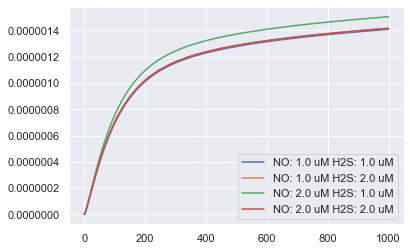

In [266]:
tspan = np.linspace(0, 1000, 1001)

for NO_0 in [1.0,  2.0]:
    for H2S_0 in [1.0, 2.0]:
        y0 = [NO_0*1e-6, H2S_0*1e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2e-9, 0.0, 0.0, 0.0]
        
        kvals = (1e-2, 1e6, 1e9, 1e-2)

        sim = sim_t(tspan, kvals, y0)
        I = sim*96500
        #plt.plot(tspan, no, 'b')
        #plt.plot(tspan, h2s, 'y')
        plt.plot(tspan, I, label = 'NO: ' + str(NO_0) + ' uM H2S: ' + str(H2S_0)+ ' uM')

plt.legend()
plt.show()

Cargo los experimentos de H2S

In [279]:
WD = '/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas H2S-NO/'
experiments = {}
for file in os.listdir(WD):
    name = re.split('_|.txt', file)[0:4]
    name[1] = re.split('uM', name[1])[0]
    name[3] = re.split('uM', name[3])
    name[1] = float(name[1])
    if name[3][1] == '':
        del name[3][1]
        name.append('A')
    elif name[3][1] == 'b':
        del name[3][1]
        name.append('B')
    name[3] = name[3][0].replace('(','.')
    name[3] = float(name[3].replace(')',''))

    if name[0] == 'NO':
        exp = (name[1], name[3], name[4])
    else:
        exp = (name[3], name[1], name[4])
        
    df = pd.read_csv( WD + file, header = None, sep = '\t')
    df.columns = ['time','I']
    
    df.time = pd.to_timedelta(df.time, unit = 'minutes')
    df = df.set_index('time')
    
    
    df['I'] = df['I']*1.3*1e-6 #Corriente en amperes 
    
    experiments[exp] = df

In [280]:
def leastsq_func(params, *args):
    n_points_per_experiment = args[0]
    x_data = args[1]
    y_data = args[2]
    conc_per_experiment = args[3]
    
    #factor = params[0]
    k_vals = [10**i for i in params]
    
    yfit = np.empty(y_data.shape)
    
    left = 0
    for i, val in enumerate(n_points_per_experiment):
        right = left + val
        yfit[left:right] = 96500*sim_t(x_data[left:right], k_vals, conc_per_experiment[i])
        left = right
    return y_data - yfit

def build_multiple_experiments2(experiments, use_list, ini_point, fin_point):
    usable_experiments = sorted(list(use_list))
    
    x_data = []
    y_data = []
    n_points = []
    step = 1
    for exp in usable_experiments:
        x_data.extend(experiments[exp].I[ini_point:fin_point:step].index.total_seconds().values)
        y_data.extend(experiments[exp].I[ini_point:fin_point:step].values)
        n_points.append(len(experiments[exp].I[ini_point:fin_point:step].index.total_seconds().values))
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data, n_points, usable_experiments

In [281]:
ini_point = 0
fin_point = -1

use_list = [(2.0, 2.0, 'A')]
#use_list = list(experiments.keys())

x_exp, y_exp, n_points, conc_list = build_multiple_experiments2(experiments, use_list, ini_point, fin_point)

y0_vec = []
for i in conc_list:
    y0 = [i[0], i[1], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2e-3, 0.0, 0.0, 0.0]
    y0_vec.append(y0)
y0_vec = np.array(y0_vec)*1e-6

In [288]:
p0 = [1e-2, 1e5, 1e3, 1e-2]
params = [np.log10(i) for i in p0]
args = (n_points, x_exp, y_exp, y0_vec)
result = leastsq(leastsq_func, params, args = args)
k_vals = [10**i for i in result[0]]
print(k_vals)

/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<string>:3: RuntimeWarning: invalid value encountered in double_scalars
/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnin

[0.01269038260124202, 210177.00543702312, 1263.5644498561057, 2.1436503218884447e+21]


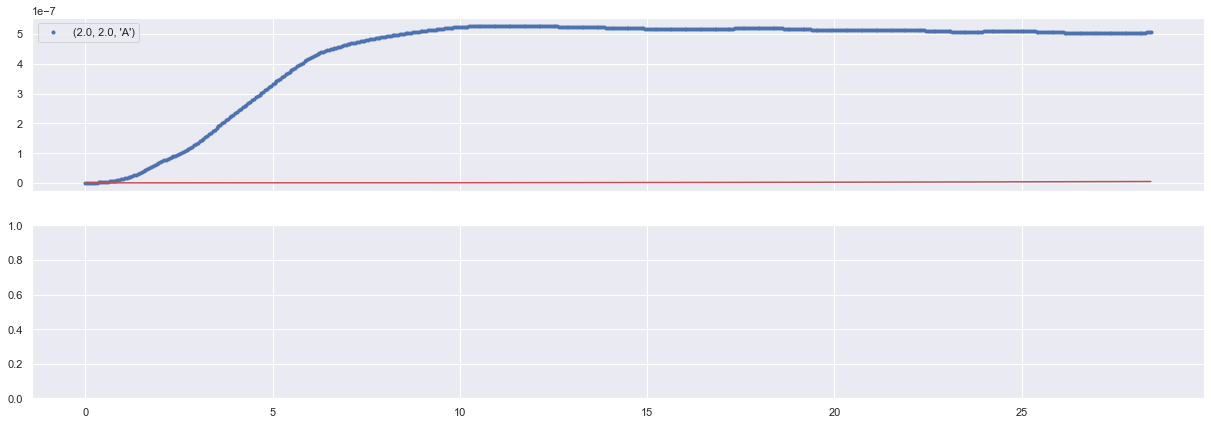

In [289]:

fig, ax = plt.subplots(len(conc_list)+1, figsize = (21,len(conc_list)*7), sharex=True)
for i, exp in enumerate(conc_list):
    
    tspan = experiments[exp].I[ini_point:fin_point].index.total_seconds().values
    exp_data = experiments[exp].I[ini_point:fin_point].values
    
    ax[i].plot(tspan, exp_data , 'b.', label = str(exp))
    ax[i].plot(tspan, 96500*sim_t(tspan, k_vals, y0_vec[i]),'r')
    ax[i].legend()